**Installing CatBoost Library**

In [68]:
#Installing CatBoost Library
!pip install catboost

**Importing Libraries**

In [69]:
#Importing Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from catboost import Pool
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier



**Mounting google drive to read data.**

In [70]:
# Mounting google drive to read data.
from google.colab import drive

In [71]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
data = pd.read_csv('/content/drive/MyDrive/credit_risk_data/UCI_Credit_Card.csv')

**Data Cleaning and Transformation**

In [73]:
data

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.00,2,2,1,24,2,2,-1,-1,-2,-2,3913.00,3102.00,689.00,0.00,0.00,0.00,0.00,689.00,0.00,0.00,0.00,0.00,1
1,2,120000.00,2,2,2,26,-1,2,0,0,0,2,2682.00,1725.00,2682.00,3272.00,3455.00,3261.00,0.00,1000.00,1000.00,1000.00,0.00,2000.00,1
2,3,90000.00,2,2,2,34,0,0,0,0,0,0,29239.00,14027.00,13559.00,14331.00,14948.00,15549.00,1518.00,1500.00,1000.00,1000.00,1000.00,5000.00,0
3,4,50000.00,2,2,1,37,0,0,0,0,0,0,46990.00,48233.00,49291.00,28314.00,28959.00,29547.00,2000.00,2019.00,1200.00,1100.00,1069.00,1000.00,0
4,5,50000.00,1,2,1,57,-1,0,-1,0,0,0,8617.00,5670.00,35835.00,20940.00,19146.00,19131.00,2000.00,36681.00,10000.00,9000.00,689.00,679.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.00,1,3,1,39,0,0,0,0,0,0,188948.00,192815.00,208365.00,88004.00,31237.00,15980.00,8500.00,20000.00,5003.00,3047.00,5000.00,1000.00,0
29996,29997,150000.00,1,3,2,43,-1,-1,-1,-1,0,0,1683.00,1828.00,3502.00,8979.00,5190.00,0.00,1837.00,3526.00,8998.00,129.00,0.00,0.00,0
29997,29998,30000.00,1,2,2,37,4,3,2,-1,0,0,3565.00,3356.00,2758.00,20878.00,20582.00,19357.00,0.00,0.00,22000.00,4200.00,2000.00,3100.00,1
29998,29999,80000.00,1,3,1,41,1,-1,0,0,0,-1,-1645.00,78379.00,76304.00,52774.00,11855.00,48944.00,85900.00,3409.00,1178.00,1926.00,52964.00,1804.00,1


In [74]:
#One hot encoding for categorical variables
{'EDUCATION': 'EDU'}.items()

dict_items([('EDUCATION', 'EDU')])

In [75]:
def onehot_encode(df, column_dict):
    df = df.copy()
    for column, prefix in column_dict.items():
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

In [76]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Drop ID
    df = df.drop('ID', axis=1)
    
    df = onehot_encode(
        df,
        {
            'EDUCATION': 'EDU',
            'MARRIAGE': 'MAR'
        }
    )
    
    # Split df into X and y
    y = df['default.payment.next.month'].copy()
    X = df.drop('default.payment.next.month', axis=1).copy()
    
    # Scale X with a standard scaler (so that values are between -1 and 1)
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    return X, y

In [77]:
X, y = preprocess_inputs(data)

In [78]:
X

,LIMIT_BAL,SEX,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDU_0,EDU_1,EDU_2,EDU_3,EDU_4,EDU_5,EDU_6,MAR_0,MAR_1,MAR_2,MAR_3
0,-1.14,0.81,-1.25,1.79,1.78,-0.70,-0.67,-1.53,-1.49,-0.64,-0.65,-0.67,-0.67,-0.66,-0.65,-0.34,-0.23,-0.30,-0.31,-0.31,-0.29,-0.02,-0.74,1.07,-0.44,-0.06,-0.10,-0.04,-0.04,1.09,-1.07,-0.10
1,-0.37,0.81,-1.03,-0.87,1.78,0.14,0.19,0.23,1.99,-0.66,-0.67,-0.64,-0.62,-0.61,-0.60,-0.34,-0.21,-0.24,-0.24,-0.31,-0.18,-0.02,-0.74,1.07,-0.44,-0.06,-0.10,-0.04,-0.04,-0.91,0.94,-0.10
2,-0.60,0.81,-0.16,0.01,0.11,0.14,0.19,0.23,0.25,-0.30,-0.49,-0.48,-0.45,-0.42,-0.39,-0.25,-0.19,-0.24,-0.24,-0.25,-0.01,-0.02,-0.74,1.07,-0.44,-0.06,-0.10,-0.04,-0.04,-0.91,0.94,-0.10
3,-0.91,0.81,0.16,0.01,0.11,0.14,0.19,0.23,0.25,-0.06,-0.01,0.03,-0.23,-0.19,-0.16,-0.22,-0.17,-0.23,-0.24,-0.24,-0.24,-0.02,-0.74,1.07,-0.44,-0.06,-0.10,-0.04,-0.04,1.09,-1.07,-0.10
4,-0.91,-1.23,2.33,-0.87,0.11,-0.70,0.19,0.23,0.25,-0.58,-0.61,-0.16,-0.35,-0.35,-0.33,-0.22,1.34,0.27,0.27,-0.27,-0.26,-0.02,-0.74,1.07,-0.44,-0.06,-0.10,-0.04,-0.04,1.09,-1.07,-0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.40,-1.23,0.38,0.01,0.11,0.14,0.19,0.23,0.25,1.87,2.02,2.33,0.70,-0.15,-0.38,0.17,0.61,-0.01,-0.11,0.01,-0.24,-0.02,-0.74,-0.94,2.26,-0.06,-0.10,-0.04,-0.04,1.09,-1.07,-0.10
29996,-0.13,-1.23,0.82,-0.87,-0.72,-0.70,-0.67,0.23,0.25,-0.67,-0.67,-0.63,-0.53,-0.58,-0.65,-0.23,-0.10,0.21,-0.30,-0.31,-0.29,-0.02,-0.74,-0.94,2.26,-0.06,-0.10,-0.04,-0.04,-0.91,0.94,-0.10
29997,-1.06,-1.23,0.16,3.57,2.62,1.81,-0.67,0.23,0.25,-0.65,-0.64,-0.64,-0.35,-0.32,-0.33,-0.34,-0.26,0.95,-0.04,-0.18,-0.12,-0.02,-0.74,1.07,-0.44,-0.06,-0.10,-0.04,-0.04,-0.91,0.94,-0.10
29998,-0.67,-1.23,0.60,0.90,-0.72,0.14,0.19,0.23,-0.62,-0.72,0.41,0.42,0.15,-0.47,0.17,4.84,-0.11,-0.23,-0.19,3.15,-0.19,-0.02,-0.74,-0.94,2.26,-0.06,-0.10,-0.04,-0.04,1.09,-1.07,-0.10


In [79]:
#To check for Data Imbalance
y.value_counts()

0    23364
1     6636
Name: default.payment.next.month, dtype: int64

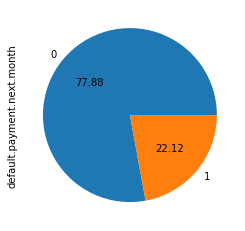

In [80]:
# Show pie plot 
y.value_counts().plot.pie(autopct='%.2f')

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)

In [82]:
df = X_train
df.target = y_train

features = X_train
labels = y_train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


**Feature Selection:**
We have used Six Different Feature Selection algorithm(Feed Forward, Weight of Evidence(WOE), Anova, Extra trees, Random forest, and L1 feature selection) combined using Voting Techniques(Unanimous, Majority, Hard-voting, Soft-voting, Any_Vote)

1. Weight of Evidence(WOE)

In [83]:
# Implementation for Weight of Evidence(WOE) feature Selection
# import packages
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv) 

In [84]:
final_iv, IV = data_vars(df,df.target)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [85]:
IV = IV.rename(columns={'VAR_NAME':'index'})

In [86]:
IV.sort_values(['IV'],ascending=0)

,index,IV
19,PAY_0,0.70
20,PAY_2,0.56
21,PAY_3,0.43
22,PAY_4,0.37
23,PAY_5,0.35
24,PAY_6,0.31
14,LIMIT_BAL,0.16
25,PAY_AMT1,0.15
26,PAY_AMT2,0.14
27,PAY_AMT3,0.12


2. Random Forest Feature Selection

In [87]:
#Implementation for Random Forest Feature Selection
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

clf.fit(features,labels)

preds = clf.predict(features)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(preds,labels)
print(accuracy)

0.9992857142857143


In [88]:
from pandas import DataFrame
VI = DataFrame(clf.feature_importances_, columns = ["RF"], index=features.columns)

In [89]:
VI = VI.reset_index()

In [90]:
VI.sort_values(['RF'],ascending=0)

,index,RF
3,PAY_0,0.10
2,AGE,0.07
0,LIMIT_BAL,0.06
9,BILL_AMT1,0.06
10,BILL_AMT2,0.05
11,BILL_AMT3,0.05
14,BILL_AMT6,0.05
15,PAY_AMT1,0.05
12,BILL_AMT4,0.05
13,BILL_AMT5,0.05


3. Feed Forward Feature Selection

In [91]:
# Implementation of Feed Forward Feature Selection
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
rfe = SFS(model, n_features_to_select =18, direction="forward")
fit = rfe.fit(features, labels)

In [92]:
from pandas import DataFrame
Selected = DataFrame(rfe.support_, columns = ["SFS"], index=features.columns)
Selected = Selected.reset_index()

In [93]:
Selected

,index,SFS
0,LIMIT_BAL,False
1,SEX,True
2,AGE,False
3,PAY_0,True
4,PAY_2,False
5,PAY_3,False
6,PAY_4,False
7,PAY_5,False
8,PAY_6,False
9,BILL_AMT1,False


In [94]:
Selected[Selected['SFS'] == True]

,index,SFS
1,SEX,True
3,PAY_0,True
12,BILL_AMT4,True
14,BILL_AMT6,True
16,PAY_AMT2,True
17,PAY_AMT3,True
18,PAY_AMT4,True
19,PAY_AMT5,True
20,PAY_AMT6,True
21,EDU_0,True


4. Extra Tree Feature Selection

In [95]:
# Implementation of Extra Tree Feature Selection
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(features, labels)

print(model.feature_importances_)

[0.06436465 0.01314242 0.0667376  0.09539675 0.05207926 0.0387769
 0.03301135 0.0330841  0.03257143 0.04985531 0.04613306 0.04460012
 0.0445899  0.04298824 0.04423564 0.04394363 0.04236191 0.0417129
 0.04121502 0.04295161 0.04591339 0.00002561 0.00675062 0.00852429
 0.00674113 0.00048388 0.00133545 0.00054047 0.00046798 0.00662654
 0.00665421 0.00218463]


In [96]:
from pandas import DataFrame
FI = DataFrame(model.feature_importances_, columns = ["Extratrees"], index=features.columns)

In [97]:
FI = FI.reset_index()

In [98]:
FI.sort_values(['Extratrees'],ascending=0)

,index,Extratrees
3,PAY_0,0.10
2,AGE,0.07
0,LIMIT_BAL,0.06
4,PAY_2,0.05
9,BILL_AMT1,0.05
10,BILL_AMT2,0.05
20,PAY_AMT6,0.05
11,BILL_AMT3,0.04
12,BILL_AMT4,0.04
14,BILL_AMT6,0.04


In [99]:
df1 = df.copy()

from sklearn import preprocessing
from collections import defaultdict
d = defaultdict(preprocessing.LabelEncoder)
# Encoding the categorical variable
fit = df1.apply(lambda x: d[x.name].fit_transform(x))

#Convert the categorical columns based on encoding
for i in list(d.keys()):
    df1[i] = d[i].transform(df1[i])

In [100]:
features1 = df1
labels1 = y_train

5. Anova Feature Selection

In [101]:
# Implementation of Anova Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

model = SelectKBest(score_func=f_classif, k=5)
fit = model.fit(features, labels)

In [102]:
import numpy
numpy.set_printoptions(suppress=True)
print(fit.scores_)

[ 478.37763206   45.14830492    2.41108746 2481.58194377 1588.01712611
 1289.12225824 1064.85049285  956.48100489  828.13046403    8.94196431
    4.9171461     4.54933417    3.18391968    1.2999111     0.5133622
  108.09081351   77.73066702   78.08504983   78.4381094    54.63531977
   66.27779439    2.87544689   44.04984487   15.87424407   29.76269286
   12.23815839   28.22721091    1.30625569    2.18969906   14.20878746
   14.98607812    1.2045871 ]


In [103]:
from pandas import DataFrame
pd.options.display.float_format = '{:.2f}'.format
anova = DataFrame(fit.scores_, columns = ["Anova"], index=features1.columns)

In [104]:
anova = anova.reset_index()

In [105]:
anova.sort_values('Anova',ascending=0)

,index,Anova
3,PAY_0,2481.58
4,PAY_2,1588.02
5,PAY_3,1289.12
6,PAY_4,1064.85
7,PAY_5,956.48
8,PAY_6,828.13
0,LIMIT_BAL,478.38
15,PAY_AMT1,108.09
18,PAY_AMT4,78.44
17,PAY_AMT3,78.09


6. L1 based Feature Selection

In [106]:
# Implementation of L1 based Feature Selection
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

In [107]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(features, labels)
model = SelectFromModel(lsvc,prefit=True)

In [108]:
from pandas import DataFrame
l1 = DataFrame(model.get_support(), columns = ["L1"], index=features.columns)

In [109]:
l1 = l1.reset_index()

In [110]:
l1[l1['L1'] == True]

,index,L1
0,LIMIT_BAL,True
1,SEX,True
2,AGE,True
3,PAY_0,True
4,PAY_2,True
5,PAY_3,True
6,PAY_4,True
7,PAY_5,True
8,PAY_6,True
9,BILL_AMT1,True


**Voting mechanism for feature selection**

In [111]:
# Implementing Voting mechanism for feature selection
#Combining outputs of individual feature selection methods
from functools import reduce
dfs = [IV, VI, Selected, FI, anova, l1]
final_results = reduce(lambda left,right: pd.merge(left,right,on='index'), dfs)

In [112]:
final_results.head()

,index,IV,RF,SFS,Extratrees,Anova,L1
0,AGE,0.00,0.07,False,0.07,2.41,True
1,BILL_AMT1,0.01,0.06,False,0.05,8.94,True
2,BILL_AMT2,0.00,0.05,False,0.05,4.92,False
3,BILL_AMT3,0.00,0.05,False,0.04,4.55,False
4,BILL_AMT4,0.00,0.05,True,0.04,3.18,False


In [113]:
final_results.columns

Index(['index', 'IV', 'RF', 'SFS', 'Extratrees', 'Anova', 'L1'], dtype='object')

In [114]:
#Changing the datatypes to be uniform accross all the columns and computing the final score column
columns = ['IV', 'RF', 'Extratrees', 'Anova']

score_table = pd.DataFrame({},[])
score_table['index'] = final_results['index']

for i in columns:
    score_table[i] = final_results['index'].isin(list(final_results.nlargest(16,i)['index'])).astype(int)
    
score_table['RFE'] = final_results['SFS'].astype(int)
score_table['L1'] = final_results['L1'].astype(int)

In [115]:
score_table['final_score'] = score_table.sum(axis=1)

In [116]:
score_table.sort_values('final_score',ascending=0)

,index,IV,RF,Extratrees,Anova,RFE,L1,final_score
30,PAY_AMT6,1,1,1,1,1,1,6
29,PAY_AMT5,1,1,1,1,1,1,6
28,PAY_AMT4,1,1,1,1,1,1,6
27,PAY_AMT3,1,1,1,1,1,1,6
26,PAY_AMT2,1,1,1,1,1,1,6
19,PAY_0,1,1,1,1,1,1,6
25,PAY_AMT1,1,1,1,1,0,1,5
20,PAY_2,1,1,1,1,0,1,5
14,LIMIT_BAL,1,1,1,1,0,1,5
31,SEX,1,0,0,1,1,1,4


In [117]:
dfScore2 = score_table[score_table.final_score > 2]

In [118]:
len(dfScore2)

21

In [119]:
dfScore2["index"]

0           AGE
1     BILL_AMT1
4     BILL_AMT4
5     BILL_AMT5
6     BILL_AMT6
8         EDU_1
12        EDU_5
14    LIMIT_BAL
19        PAY_0
20        PAY_2
21        PAY_3
22        PAY_4
23        PAY_5
24        PAY_6
25     PAY_AMT1
26     PAY_AMT2
27     PAY_AMT3
28     PAY_AMT4
29     PAY_AMT5
30     PAY_AMT6
31          SEX
Name: index, dtype: object

In [120]:
X_train = X_train[dfScore2["index"]]
X_test = X_test[dfScore2["index"]]

In [121]:
X_train

,AGE,BILL_AMT1,BILL_AMT4,BILL_AMT5,BILL_AMT6,EDU_1,EDU_5,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX
16395,0.06,-0.30,-0.37,-0.50,-0.59,1.35,-0.10,1.18,0.01,0.11,0.14,0.19,0.23,0.25,-0.04,-0.04,-0.24,-0.12,-0.31,0.10,0.81
21448,-0.60,-0.69,1.99,1.82,1.33,1.35,-0.10,2.10,-0.87,-0.72,-0.70,0.19,0.23,0.25,-0.30,3.54,7.09,-0.12,0.67,2.61,0.81
20034,0.92,-0.70,-0.67,-0.66,-0.65,-0.74,-0.10,-0.06,-1.76,-1.56,-1.53,-1.52,-1.53,-1.49,-0.34,-0.26,-0.30,-0.31,-0.31,-0.29,0.81
25755,-0.60,0.68,0.93,0.51,0.14,-0.74,-0.10,-0.37,0.01,0.11,0.14,0.19,0.23,0.25,-0.12,-0.02,-0.06,-0.12,-0.18,-0.20,0.81
1438,2.01,-0.04,-0.24,-0.20,-0.19,-0.74,-0.10,-0.91,0.90,1.78,0.14,0.19,0.23,0.25,-0.34,-0.20,-0.23,-0.21,-0.25,-0.21,-1.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28636,0.16,-0.51,-0.45,-0.40,-0.39,-0.74,-0.10,1.64,0.01,0.11,0.14,0.19,0.23,1.99,-0.27,-0.20,-0.23,-0.19,-0.31,-0.12,0.81
17730,2.01,-0.70,-0.63,-0.62,-0.54,1.35,-0.10,1.48,0.90,-1.56,-1.53,-0.67,0.23,-0.62,-0.34,-0.26,-0.15,-0.31,0.14,-0.29,0.81
28030,-0.70,-0.05,-0.06,-0.52,-0.50,-0.74,-0.10,-0.91,0.01,0.11,0.14,0.19,0.23,0.25,-0.22,-0.17,-0.21,-0.24,-0.29,-0.27,0.81
15725,-1.57,-0.31,-0.19,-0.18,-0.37,-0.74,-0.10,-1.06,0.01,0.11,0.14,0.19,0.23,0.25,-0.22,-0.17,-0.18,-0.20,-0.29,-0.29,0.81


SMOTE Oversampling Technique

In [122]:
#Implementation of SMOTE for Data Balancing
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)
X_test, y_test = oversample.fit_resample(X_test, y_test)

In [123]:
X_train

,AGE,BILL_AMT1,BILL_AMT4,BILL_AMT5,BILL_AMT6,EDU_1,EDU_5,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX
0,0.06,-0.30,-0.37,-0.50,-0.59,1.35,-0.10,1.18,0.01,0.11,0.14,0.19,0.23,0.25,-0.04,-0.04,-0.24,-0.12,-0.31,0.10,0.81
1,-0.60,-0.69,1.99,1.82,1.33,1.35,-0.10,2.10,-0.87,-0.72,-0.70,0.19,0.23,0.25,-0.30,3.54,7.09,-0.12,0.67,2.61,0.81
2,0.92,-0.70,-0.67,-0.66,-0.65,-0.74,-0.10,-0.06,-1.76,-1.56,-1.53,-1.52,-1.53,-1.49,-0.34,-0.26,-0.30,-0.31,-0.31,-0.29,0.81
3,-0.60,0.68,0.93,0.51,0.14,-0.74,-0.10,-0.37,0.01,0.11,0.14,0.19,0.23,0.25,-0.12,-0.02,-0.06,-0.12,-0.18,-0.20,0.81
4,2.01,-0.04,-0.24,-0.20,-0.19,-0.74,-0.10,-0.91,0.90,1.78,0.14,0.19,0.23,0.25,-0.34,-0.20,-0.23,-0.21,-0.25,-0.21,-1.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32619,0.61,-0.67,-0.64,-0.65,-0.63,-0.74,-0.10,0.12,-0.87,1.78,-0.70,-0.67,-0.23,-0.62,-0.34,-0.21,-0.19,-0.30,-0.24,-0.24,0.81
32620,-0.52,-0.70,-0.67,-0.66,-0.65,1.35,-0.10,1.59,0.90,-1.56,-1.53,-1.52,-1.53,-1.49,-0.34,-0.26,-0.30,-0.31,-0.31,-0.29,-1.23
32621,1.34,-0.63,-0.60,-0.59,-0.60,-0.74,-0.10,-0.84,-0.91,-0.76,-0.73,-0.67,-0.61,-0.58,-0.02,0.15,-0.02,-0.07,-0.16,-0.18,0.81
32622,1.47,-0.19,-0.09,-0.45,-0.53,-0.74,-0.10,-0.97,0.01,0.11,1.81,1.90,0.23,0.25,-0.17,-0.13,-0.27,-0.26,-0.23,-0.24,0.81


**Modelling**

In [124]:
# For Model Performance
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [62]:
## Hyperparameter optimization using GridSearchCV
from sklearn.model_selection import  RandomizedSearchCV, GridSearchCV

In [63]:
## Hyper Parameter Optimization

params_xgb={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

In [ ]:
classifier = XGBClassifier() 
random_search_xgb=RandomizedSearchCV(classifier,param_distributions=params_xgb,n_iter=5,scoring='roc_auc',n_jobs=-1,verbose=3, cv=2)
#grid_xgb = GridSearchCV(classifier, param_grid=params_xgb, verbose=1,cv=2, n_jobs=-1)

In [ ]:
random_search_xgb.fit(X_train,y_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


RandomizedSearchCV(cv=2, estimator=XGBClassifier(), n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   scoring='roc_auc', verbose=3)

In [ ]:
random_search_xgb.best_estimator_

XGBClassifier(colsample_bytree=0.7, gamma=0.3, learning_rate=0.2, max_depth=15,
              min_child_weight=5)

In [ ]:
random_search_xgb.best_params_

{'colsample_bytree': 0.7,
 'gamma': 0.3,
 'learning_rate': 0.2,
 'max_depth': 15,
 'min_child_weight': 5}

**XGBoost**

In [125]:
#Implementing XGBoost classifier with hyper-parameter tuning
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.03, gamma=0.2,
              learning_rate=0.08, max_delta_step=0, max_depth=15,
              min_child_weight=7, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)# Define classifier
xgb.fit(X_train, y_train) 

# Make predictions
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

# Training set performance
xgb_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
xgb_train_mcc = matthews_corrcoef(y_train, y_train_pred) # Calculate MCC
xgb_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score
xgb_train_auc = roc_auc_score(y_train, y_train_pred)


# Test set performance
xgb_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
xgb_test_mcc = matthews_corrcoef(y_test, y_test_pred) # Calculate MCC
xgb_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score
xgb_test_auc = roc_auc_score(y_test, y_test_pred)


print('Model performance for Training set')
print('- Accuracy: %s' % xgb_train_accuracy)
print('- MCC: %s' % xgb_train_mcc)
print('- F1 score: %s' % xgb_train_f1)
print('Train AUC: %.3f' % xgb_train_auc)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % xgb_test_accuracy)
print('- MCC: %s' % xgb_test_mcc)
print('- F1 score: %s' % xgb_test_f1)
print('Test AUC: %.3f' % xgb_test_auc)

Model performance for Training set
- Accuracy: 0.8786782736635605
- MCC: 0.7646526222273621
- F1 score: 0.8780994800171565
Train AUC: 0.879
----------------------------------
Model performance for Test set
- Accuracy: 0.8401162790697675
- MCC: 0.6854082664484761
- F1 score: 0.8395126245018969
Test AUC: 0.840


In [ ]:
grid_params_lightgbm = {'learning_rate': [0.01], 'n_estimators': [8, 24],
                   'num_leaves': [6, 8, 12, 16], 'boosting_type': ['gbdt'], 
                   'objective': ['binary'], 'seed': [500],
                   'colsample_bytree': [0.65, 0.75, 0.8], 
                   'subsample': [0.7, 0.75], 'reg_alpha': [1, 2, 6],
                   'reg_lambda': [1, 2, 6]}

In [ ]:
classifier = LGBMClassifier()
grid = GridSearchCV(classifier, param_grid=grid_params_lightgbm, verbose=1, cv=2, n_jobs=-1)

In [ ]:
grid.fit(X_train,y_train)

In [ ]:
grid.best_estimator_

In [ ]:
grid.best_params_

**LightGBM**

In [126]:
#Implementing LGBM classifier with hyper-parameter tuning

lgbm = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.65,
               importance_type='split', learning_rate=0.4, max_depth=-1,
               min_child_samples=24, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=20, n_jobs=-1, num_leaves=16, objective='binary',
               random_state=None, reg_alpha=1, reg_lambda=1, seed=500,
               silent=True, subsample=0.7, subsample_for_bin=200000,
               subsample_freq=0) # Define classifier
lgbm.fit(X_train, y_train) # Train model

# Make predictions
y_train_pred = lgbm.predict(X_train)
y_test_pred = lgbm.predict(X_test)

# Training set performance
lgbm_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
lgbm_train_mcc = matthews_corrcoef(y_train, y_train_pred) # Calculate MCC
lgbm_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score
lgbm_train_auc = roc_auc_score(y_train, y_train_pred)

# Test set performance
lgbm_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
lgbm_test_mcc = matthews_corrcoef(y_test, y_test_pred) # Calculate MCC
lgbm_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score
lgbm_test_auc = roc_auc_score(y_test, y_test_pred)

print('Model performance for Training set')
print('- Accuracy: %s' % lgbm_train_accuracy)
print('- MCC: %s' % lgbm_train_mcc)
print('- F1 score: %s' % lgbm_train_f1)
print('Train AUC: %.3f' % lgbm_train_auc)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % lgbm_test_accuracy)
print('- MCC: %s' % lgbm_test_mcc)
print('- F1 score: %s' % lgbm_test_f1)
print('Test AUC: %.3f' % lgbm_test_auc)

Model performance for Training set
- Accuracy: 0.8408840117704757
- MCC: 0.6848068443319154
- F1 score: 0.8405309760264402
Train AUC: 0.841
----------------------------------
Model performance for Test set
- Accuracy: 0.8372802041973908
- MCC: 0.6770899296309715
- F1 score: 0.8369762551042377
Test AUC: 0.837


In [ ]:
parameters = {'depth'         : [4,5,6,7,8,9, 10],
                 'learning_rate' : [0.01,0.02,0.03,0.04],
                  'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]
                 }

In [ ]:
cat = CatBoostClassifier()
cat_grid = GridSearchCV(cat, param_grid=parameters, cv = 2, verbose=1, n_jobs=-1)

In [ ]:
cat_grid.fit(X_train,y_train)

Fitting 2 folds for each of 280 candidates, totalling 560 fits
0:	learn: 0.6800838	total: 95.7ms	remaining: 9.48s
1:	learn: 0.6681832	total: 134ms	remaining: 6.55s
2:	learn: 0.6575441	total: 172ms	remaining: 5.55s
3:	learn: 0.6478983	total: 209ms	remaining: 5.03s
4:	learn: 0.6391750	total: 249ms	remaining: 4.74s
5:	learn: 0.6310363	total: 288ms	remaining: 4.51s
6:	learn: 0.6231967	total: 343ms	remaining: 4.56s
7:	learn: 0.6156185	total: 382ms	remaining: 4.39s
8:	learn: 0.6092465	total: 421ms	remaining: 4.25s
9:	learn: 0.6034649	total: 459ms	remaining: 4.13s
10:	learn: 0.5977552	total: 499ms	remaining: 4.04s
11:	learn: 0.5919150	total: 537ms	remaining: 3.94s
12:	learn: 0.5869068	total: 580ms	remaining: 3.88s
13:	learn: 0.5821674	total: 620ms	remaining: 3.81s
14:	learn: 0.5775081	total: 664ms	remaining: 3.76s
15:	learn: 0.5733128	total: 707ms	remaining: 3.71s
16:	learn: 0.5693462	total: 744ms	remaining: 3.63s
17:	learn: 0.5659452	total: 788ms	remaining: 3.59s
18:	learn: 0.5621168	total: 

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostClassifier object at 0x7facc34ffb50>,
             n_jobs=-1,
             param_grid={'depth': [4, 5, 6, 7, 8, 9, 10],
                         'iterations': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                        100],
                         'learning_rate': [0.01, 0.02, 0.03, 0.04]},
             verbose=1)

In [ ]:
cat_grid.best_params_

{'depth': 9, 'iterations': 100, 'learning_rate': 0.04}

**CatBoost**

In [127]:
#Implementing CatBoost classifier with hyper-parameter tuning
cat = CatBoostClassifier(depth= 9, iterations= 100, learning_rate= 0.7) # Define classifier

cat.fit(X_train, y_train) # Train model

# Make predictions
y_train_pred = cat.predict(X_train)
y_test_pred = cat.predict(X_test)

# Training set performance
cat_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
cat_train_mcc = matthews_corrcoef(y_train, y_train_pred) # Calculate MCC
cat_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score

# Test set performance
cat_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
cat_test_mcc = matthews_corrcoef(y_test, y_test_pred) # Calculate MCC
cat_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score
auc_test = roc_auc_score(y_test, y_test_pred)

print('Model performance for Training set')
print('- Accuracy: %s' % cat_train_accuracy)
print('- MCC: %s' % cat_train_mcc)
print('- F1 score: %s' % cat_train_f1)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % cat_test_accuracy)
print('- MCC: %s' % cat_test_mcc)
print('- F1 score: %s' % cat_test_f1)
print('Test AUC: %.3f' % auc_test)

0:	learn: 0.5688092	total: 56.3ms	remaining: 5.58s
1:	learn: 0.5370779	total: 100ms	remaining: 4.91s
2:	learn: 0.5224183	total: 143ms	remaining: 4.64s
3:	learn: 0.5006224	total: 187ms	remaining: 4.49s
4:	learn: 0.4868603	total: 231ms	remaining: 4.39s
5:	learn: 0.4715036	total: 277ms	remaining: 4.34s
6:	learn: 0.4571566	total: 330ms	remaining: 4.38s
7:	learn: 0.4461346	total: 374ms	remaining: 4.3s
8:	learn: 0.4374436	total: 418ms	remaining: 4.23s
9:	learn: 0.4305845	total: 462ms	remaining: 4.16s
10:	learn: 0.4200668	total: 525ms	remaining: 4.25s
11:	learn: 0.4126265	total: 567ms	remaining: 4.15s
12:	learn: 0.4055589	total: 615ms	remaining: 4.12s
13:	learn: 0.3946930	total: 662ms	remaining: 4.07s
14:	learn: 0.3837100	total: 706ms	remaining: 4s
15:	learn: 0.3775128	total: 751ms	remaining: 3.94s
16:	learn: 0.3637902	total: 793ms	remaining: 3.87s
17:	learn: 0.3537167	total: 838ms	remaining: 3.82s
18:	learn: 0.3388980	total: 882ms	remaining: 3.76s
19:	learn: 0.3335822	total: 926ms	remaining:

**Stacked Ensemble**

In [128]:
# Define estimators
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimator_list = [
    ('xgb',xgb),
    ('lgbm',lgbm),
    ('cat',cat) ]

# Build stack model
stack_model = StackingClassifier(
    estimators=estimator_list, final_estimator=LGBMClassifier()
)

# Train stacked model
stack_model.fit(X_train, y_train)

# Make predictions
y_train_pred = stack_model.predict(X_train)
y_test_pred = stack_model.predict(X_test)

# Training set model performance
stack_model_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
stack_model_train_mcc = matthews_corrcoef(y_train, y_train_pred) # Calculate MCC
stack_model_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score

# Test set model performance
stack_model_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
stack_model_test_mcc = matthews_corrcoef(y_test, y_test_pred) # Calculate MCC
stack_model_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score
auc_test = roc_auc_score(y_test, y_test_pred)
print('Test AUC: %.3f' % auc_test)


print('Model performance for Training set')
print('- Accuracy: %s' % stack_model_train_accuracy)
print('- MCC: %s' % stack_model_train_mcc)
print('- F1 score: %s' % stack_model_train_f1)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % stack_model_test_accuracy)
print('- MCC: %s' % stack_model_test_mcc)
print('- F1 score: %s' % stack_model_test_f1)

0:	learn: 0.5688092	total: 52.7ms	remaining: 5.21s
1:	learn: 0.5370779	total: 97.4ms	remaining: 4.77s
2:	learn: 0.5224183	total: 141ms	remaining: 4.55s
3:	learn: 0.5006224	total: 184ms	remaining: 4.42s
4:	learn: 0.4868603	total: 229ms	remaining: 4.34s
5:	learn: 0.4715036	total: 282ms	remaining: 4.42s
6:	learn: 0.4571566	total: 336ms	remaining: 4.46s
7:	learn: 0.4461346	total: 380ms	remaining: 4.37s
8:	learn: 0.4374436	total: 430ms	remaining: 4.35s
9:	learn: 0.4305845	total: 474ms	remaining: 4.26s
10:	learn: 0.4200668	total: 523ms	remaining: 4.23s
11:	learn: 0.4126265	total: 565ms	remaining: 4.14s
12:	learn: 0.4055589	total: 610ms	remaining: 4.08s
13:	learn: 0.3946930	total: 654ms	remaining: 4.02s
14:	learn: 0.3837100	total: 699ms	remaining: 3.96s
15:	learn: 0.3775128	total: 745ms	remaining: 3.91s
16:	learn: 0.3637902	total: 790ms	remaining: 3.86s
17:	learn: 0.3537167	total: 836ms	remaining: 3.81s
18:	learn: 0.3388980	total: 879ms	remaining: 3.75s
19:	learn: 0.3335822	total: 923ms	remai